In [ ]:
!pip install pandas_datareader
!pip install six

In [20]:
import six
import sys
sys.modules['sklearn.externals.six']= six

In [23]:
import joblib
sys.modules['sklearn.externals.joblib'] = joblib

In [24]:
import os

import pandas as pd
import pandas_datareader.data as pdr

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

import seaborn as sns
plt.style.use('seaborn-whitegrid')
%matplotlib inline

import itertools

In [116]:
# 매출 TR 데이터 READ

df = pd.read_csv('./data/TRD.txt', delimiter = '\t')
df['SALE_AMT'] = df['SLPRC_UNTPRC'] * df['SALE_QTY']
df = df[{'SALE_YMD','SALE_AMT'}]
df = df[(df['SALE_YMD']>'2018-01-00') & (df['SALE_YMD']<'2020-04-00')].groupby('SALE_YMD',as_index=False).sum()
df = df[df['SALE_YMD']>'2019-11-00']
df['SALE_YMD'] = pd.to_datetime(df['SALE_YMD'])
df.set_index('SALE_YMD',inplace = True)

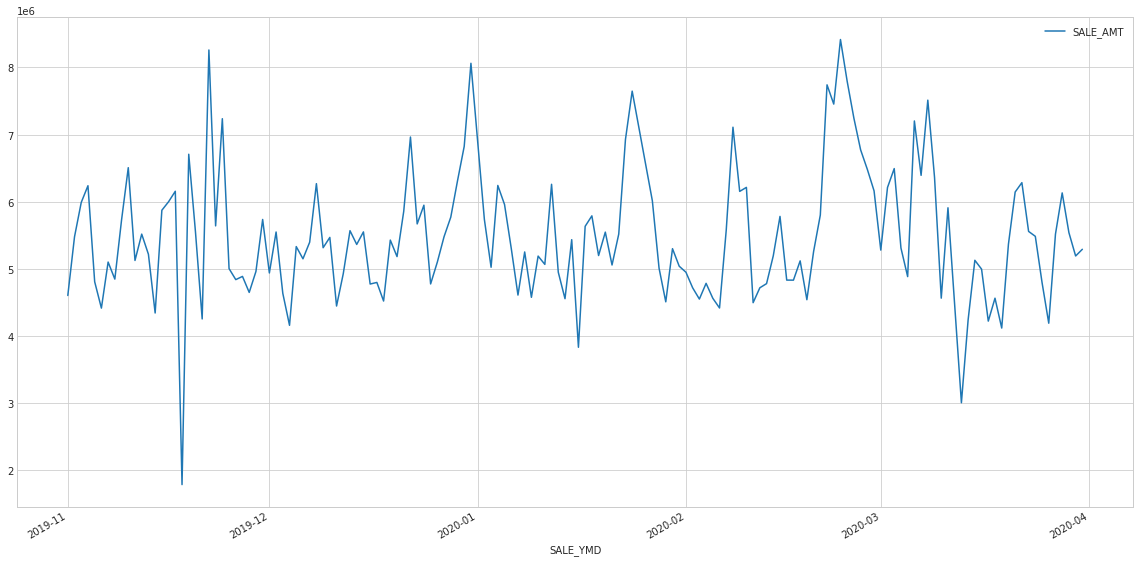

In [87]:
fig = df.plot(figsize=(20,10))

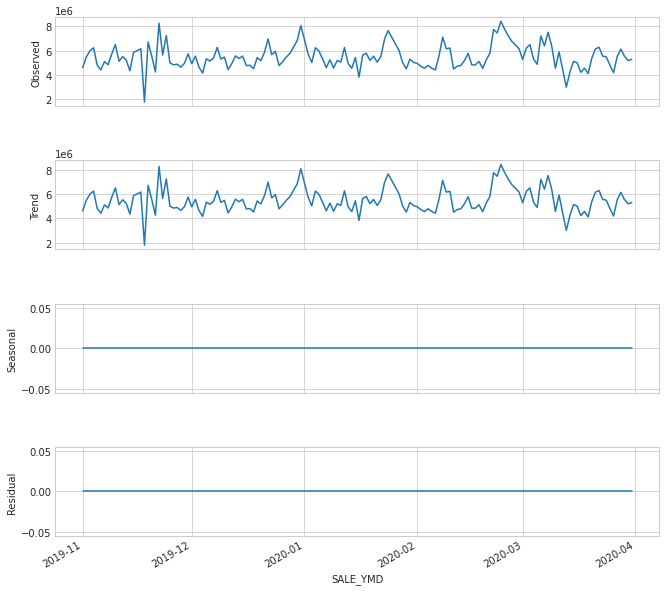

In [135]:
decomposition = sm.tsa.seasonal_decompose(df['SALE_AMT'], model='additive', freq=1)
fig = decomposition.plot()
fig.set_size_inches(10,10)
plt.show()

In [91]:
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)

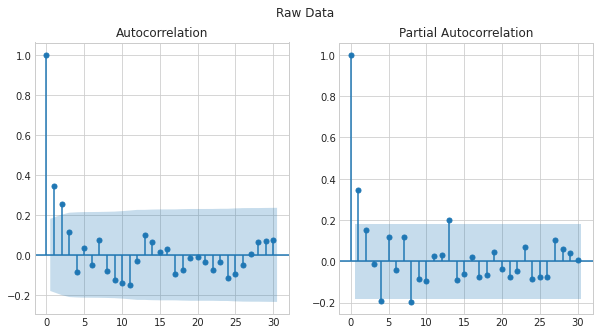

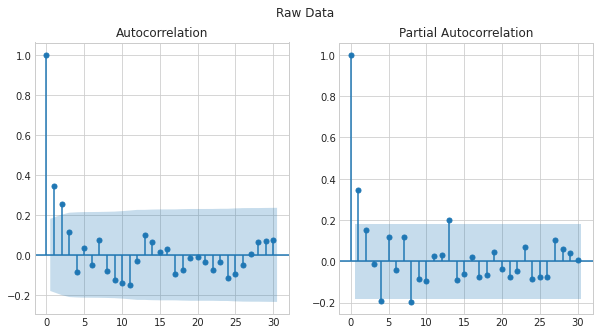

In [111]:
# ACF, PACF plot

fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(), lags=30, ax=ax[1])

In [94]:
# Differncing

diff_train_data = train_data.copy()
diff_train_data = diff_train_data['SALE_AMT'].diff()
diff_train_data = diff_train_data.dropna()
print('### Raw Data ###')
print(train_data)
print('### Dif Data ###')
print(diff_train_data)

### Raw Data ###
            SALE_AMT
SALE_YMD            
2019-11-01   4604130
2019-11-02   5478560
2019-11-03   5989990
2019-11-04   6238880
2019-11-05   4808430
...              ...
2020-02-25   7792890
2020-02-26   7243750
2020-02-27   6773160
2020-02-28   6482230
2020-02-29   6161990

[118 rows x 1 columns]
### Dif Data ###
SALE_YMD
2019-11-02     874430.0
2019-11-03     511430.0
2019-11-04     248890.0
2019-11-05   -1430450.0
2019-11-06    -392570.0
                ...    
2020-02-25    -623980.0
2020-02-26    -549140.0
2020-02-27    -470590.0
2020-02-28    -290930.0
2020-02-29    -320240.0
Name: SALE_AMT, Length: 117, dtype: float64


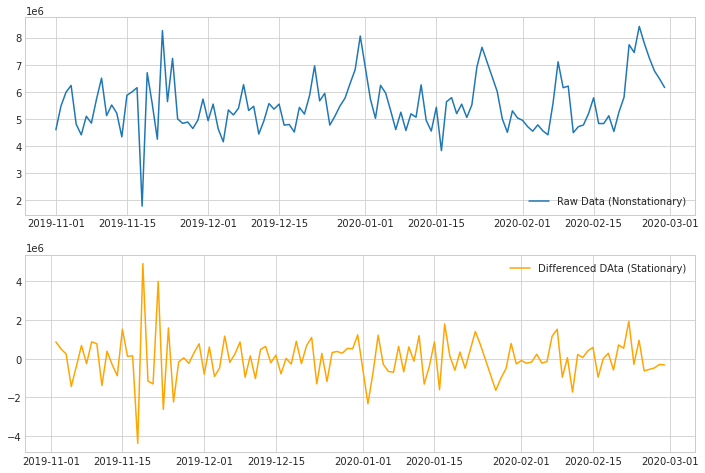

In [95]:
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(train_data['SALE_AMT'])
plt.legend(['Raw Data (Nonstationary)'])
plt.subplot(212)
plt.plot(diff_train_data, 'orange')
plt.legend(['Differenced DAta (Stationary)'])
plt.show()

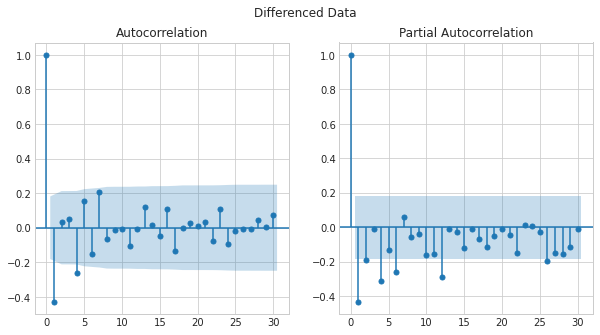

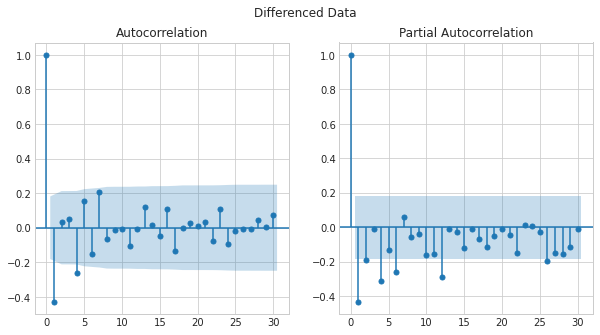

In [123]:
# Differnce ACF, PACF plot

fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Differenced Data')
sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=30, ax=ax[1])

In [97]:
model = ARIMA(train_data.values, order=(1,1,0))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  117
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1784.203
Method:                       css-mle   S.D. of innovations        1014383.855
Date:                Sun, 10 Oct 2021   AIC                           3574.405
Time:                        13:26:47   BIC                           3582.692
Sample:                             1   HQIC                          3577.770
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.332e+04   6.58e+04      0.202      0.840   -1.16e+05    1.42e+05
ar.L1.D.y     -0.4282      0.083     -5.148      0.000      -0.591      -0.265
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.3354           +0.0000j            2.3354            0.5000
-----------------------------------------------------------------------------
"""

In [115]:
p = range(0,4)
d = range(1,2)
q = range(0,3)
pdq = list(itertools.product(p,d,q))
aic=[]

for i in pdq:
    model = ARIMA(train_data.values, order=i)
    model_fit = model.fit()
    print(f'ARIMA: {i} >> AIC : {round(model_fit.aic,2)}')
    aic.append(round(model_fit.aic,2))

ARIMA: (0, 1, 0) >> AIC : 3596.2
ARIMA: (0, 1, 1) >> AIC : 3563.25
ARIMA: (0, 1, 2) >> AIC : 3559.87
ARIMA: (1, 1, 0) >> AIC : 3574.41
ARIMA: (1, 1, 1) >> AIC : 3556.29
ARIMA: (1, 1, 2) >> AIC : 3556.48
ARIMA: (2, 1, 0) >> AIC : 3572.27
ARIMA: (2, 1, 1) >> AIC : 3555.7
ARIMA: (2, 1, 2) >> AIC : 3559.41
ARIMA: (3, 1, 0) >> AIC : 3574.24
ARIMA: (3, 1, 1) >> AIC : 3557.69
ARIMA: (3, 1, 2) >> AIC : 3553.77


In [99]:
optimal = [(pdq[i],j) for i, j in enumerate(aic) if j == min(aic)]
optimal

[((3, 1, 2), 3553.77)]

In [100]:
model_opt = ARIMA(train_data.values, order=optimal[0][0])
model_opt_fit = model_opt.fit()

model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  117
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -1769.885
Method:                       css-mle   S.D. of innovations         885086.127
Date:                Sun, 10 Oct 2021   AIC                           3553.770
Time:                        13:27:46   BIC                           3573.105
Sample:                             1   HQIC                          3561.620
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5757.9791   4548.426      1.266      0.208   -3156.772    1.47e+04
ar.L1.D.y     -0.5924      0.112     -5.307      0.000      -0.811      -0.374
ar.L2.D.y      0.3675      0.106      3.482      0.001       0.161       0.574
ar.L3.D.y      0.2315      0.092      2.511      0.013       0.051       0.412
ma.L1.D.y     -0.0809      0.080     -1.014      0.313      -0.237       0.075
ma.L2.D.y     -0.9087      0.078    -11.626      0.000      -1.062      -0.756
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.6244           -0.0000j            1.6244           -0.0000
AR.2           -1.6058           -0.2828j            1.6305           -0.4723
AR.3           -1.6058           +0.2828j            1.6305            0.4723
MA.1            1.0055           +0.0000j            1.0055            0.0000
MA.2           -1.0945           +0.0000j            1.0945            0.5000
-----------------------------------------------------------------------------
"""

In [101]:
prediction = model_opt_fit.forecast(len(test_data))
predicted_value = prediction[0]
predicted_ub = prediction[2][:,0]
predicted_lb = prediction[2][:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

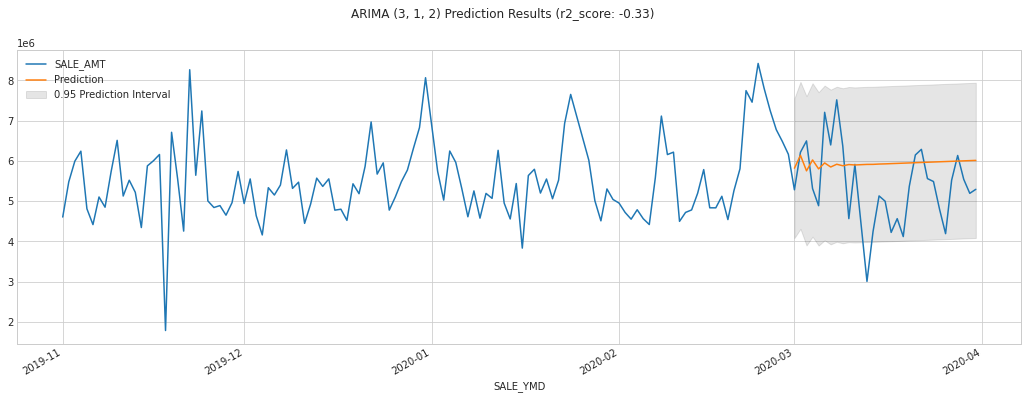

In [106]:
fig, ax = plt.subplots(figsize=(18,6))
df.plot(ax=ax)
ax.plot(predict_index, predicted_value, label='Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label = '0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA {optimal[0][0]} Prediction Results (r2_score: {round(r2,2)})')
plt.show()